In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)

In [3]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [4]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Consider splitting into multiple binary variables
 - PRE6 looks catagorical. As above.
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [27]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


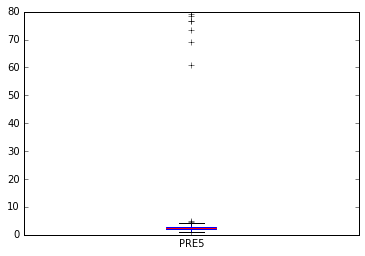

In [21]:
X.PRE5.plot(kind='box')

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors.  

In [5]:
from sklearn import preprocessing

def encode_onehot(df, column_name):
    """ Encode a catagorical column from a data frame into a dataframe of one hot features"""
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(df[[column_name]]).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names)
    return features

# encode catagorical data as one hot vectors
pre14_encoded = encode_onehot(X, 'PRE14')
pre6_encoded = encode_onehot(X, 'PRE6')
dgn_encoded = encode_onehot(X, 'DGN')

#combine into a single data frame
new_features = pd.concat([pre14_encoded, pre6_encoded, dgn_encoded], axis=1)

# drop zero var PRE32
Xp = X.drop("PRE32", axis=1)

# remove outliers via median fill
mask = Xp.PRE5 < 30
Xp.PRE5.loc[~mask] = Xp.PRE5[mask].median()

# drop the catagorical variables that have been encoded
Xp.drop(["PRE14", "PRE6", "DGN"], inplace=True, axis=1)
# add new features
Xp = pd.concat([Xp, new_features], axis=1)

# normalise data
sclr = preprocessing.StandardScaler()
Xp = pd.DataFrame(sclr.fit_transform(Xp), columns=Xp.columns)

Xp.head()

/Users/samuel/git/SEM6420/env/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,PRE4,PRE5,PRE7,PRE8,PRE9,PRE10,PRE11,PRE17,PRE19,PRE25,...,PRE6_0,PRE6_1,PRE6_2,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8
0,-1.576105,-1.517742,-0.252646,-0.457905,-0.26003,0.649462,-0.45257,-0.274352,-0.081923,-0.116248,...,-0.613308,0.728431,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
1,1.448828,2.005916,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
2,0.334379,-0.322215,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
3,0.122103,0.291279,-0.252646,-0.457905,-0.26003,0.649462,-0.45257,-0.274352,-0.081923,-0.116248,...,-0.613308,0.728431,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
4,0.387448,0.495777,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504


## Learning

We do not have access to the labels for the final testing dataset. First split the training data into a training and validation set so we have something seperate to test on. Here we're using a  simple 80/20 split. Therefore the vlidation set contains 60 examples.

In [7]:
from sklearn import cross_validation
Xt, Xv = cross_validation.train_test_split(Xp, test_size = 0.2, stratify=y.values)
Yt, Yv = y[Xt.index], y[Xv.index]
Xt.shape, Yt.shape, Xv.shape, Yv.shape

((240, 26), (240,), (60, 26), (60,))

In [173]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300)
rf.fit(Xt, Yt)
skf = cross_validation.StratifiedKFold(Yt, n_folds=5)

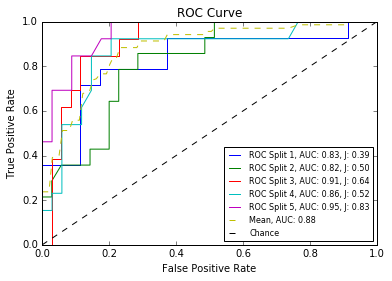

In [209]:
from scipy import interp
from sklearn import metrics
import matplotlib.pyplot as plt

def sensitivity_and_specificity(cm):
    tp, tn, fp, fn = cm[0,0], cm[1,1], cm[0,1], cm[1,0]
    specificity = tn / float(tn + fp)
    sensitivity = tp / float(tp + fn)
    return sensitivity, specificity

def youden_index(cm):
    sensitivity, specificity = sensitivity_and_specificity(cm)
    return sensitivity + specificity - 1

def roc_metrics(x_data, y_data, model):
    preds = model.predict_proba(x_data)[:, 1]
    preds_discrete = model.predict(x_data)

    fpr, tpr, _ = metrics.roc_curve(y_data, preds)
    area = metrics.auc(fpr, tpr)
    
    cm = metrics.confusion_matrix(y_data, preds_discrete)
    j_stat = youden_index(cm)
    
    return fpr, tpr, area, j_stat

def test_estimator(x_data, y_data, cv, test_func=None):
    results = []
    for i, (train_idx, test_idx) in enumerate(cv):
        x_train, x_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]
        
        rf.fit(x_train, y_train)

        if test_func is not None:
            result = test_func(x_test, y_test, rf)
            results.append(result)

    return results

def mean_roc_metrics(mets):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (fpr, tpr, _, _) in enumerate(mets):
        mean_tpr += interp(mean_fpr, fpr, tpr) 

    mean_tpr = mean_tpr / len(mets)
    area =  metrics.auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, area

def plot_roc(mets, title="ROC Curve"):
    """ Plot an ROC cruve for the given y and yhat"""
    
    for i, (fpr, tpr, area, j_stat) in enumerate(mets):      
        plt.plot(fpr, tpr, label="ROC Split %d, AUC: %.2f, J: %.2f" % ((i+1), area, j_stat))
    
    mean_fpr, mean_tpr, area = mean_roc_metrics(mets)
    plt.plot(mean_fpr, mean_tpr, "--", label="Mean, AUC: %.2f" % area)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "--", label="Chance")

    plt.title(title)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right", prop={'size':8})
    plt.show()
    
mets = test_estimator(Xt, Yt, skf, test_func=roc_metrics)
plot_roc(mets)

J statistic: 0.52
AUC: 0.86


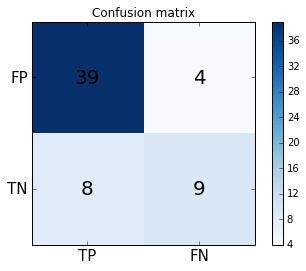

In [227]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    width, height = cm.shape
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', size=20)

    plt.xticks([0, 1], ["TP", "FN"], size=15)
    plt.yticks([0, 1], ["FP", "TN"], size=15)
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def print_summary():
    fpr, tpr, area, j = roc_metrics(Xv, Yv, rf)
    print "J statistic: %.2f" % j
    print "AUC: %.2f" % area

print_summary()

preds = rf.predict(Xv)
cm = metrics.confusion_matrix(Yv, preds)
plot_confusion_matrix(cm)